# Simulation of the Bragg Peak of a Fast Proton

Below is a graphical calculator of the energies needed to produce a Bragg peaks of a fast proton at specific target depths.  The Bragg peak is the depth at which the majority of a dose of radiation is delivered by an accelerated, massive particle. Massless radiation (like x-rays) deliver radiation that decrease (more or less) linearly over the depth of the tissue, which delivers too much radiation to healthy tissue near tumors, in the path of the beam. The use of protons for radiation therapy allows the use of the spread out Bragg peak (SOBP) in order to control the depth at which the maximum radiation dose is delivered.  This allows for finer control of radiation delivery, leading to lower incidents of side effects and sickness from irradiating healthy tissue. The analytic solution to the Bragg peak was proposed in 1997 by Bortfield.  This function, which is discussed in greater depth in my paper, involves the use of parabolic cylinder functions and gamma functions in order to produce the SOBP. As a result, the analytic solution of the SOBP is difficult to model, but if we limit ourselves to protons and limit the range of energies, then simplifications can be used to simplify modeling a SOBP.

In [7]:
import numpy as np
from scipy import signal, integrate
import matplotlib.pyplot as plt
#import ipywidgets as widgets

def proton_therapy():
    da=float(input('What is the shallowest depth of the cancerous tissue (cm)?'))
    db=float(input('What is the deepest depth of the cancerous tissue (cm)?'))
    p=float(input('What is the density of the cancerous tissue? (g/cm^3)?'))
    
    
    alpha = 1.9e-3      # Empirical constant for protons (Bortfeld & Schlegel (1996))
    D0 = 1.0            # Maximum weighted dose in the spread-out Bragg peak (SOBP)
    a = alpha**(1.0/p)
    q = 1.0 - 1.0/p #Empirical exponenet of energy loss, based on density

    E1=(1/q)*(da**2)*np.sqrt(p/2) #Estimate of energies of protons necessary to penetrate to required depths.  Based on equation in math primer; the constant was close to 1, so I left it out. Gives decent fit to data, but low estimates are a bit too low; high energy values are closer.
    E2=(1/q)*(db**2)*np.sqrt(p/2)

    def g(d):
        return np.piecewise(d,[d<0,d>0],[0,lambda d: 1.0/(p*a*d**q)]) # Stopping power based on density and particle used

    def average(func,d0,d1): #Averaging function for numerical solution
        integral,_ = integrate.quad(func,d0,d1)/(d1-d0)
        return integral

    def Bragg_peak(R,d):
        return g(R-d)

    def SOBP_analytic(d,da,db,D0):
        return np.piecewise(d,[(0<=d) & (d<da),(da<=d) & (d<=db)],[lambda d: SOBP_buildup(d,da,db,D0), D0, 0])

    def impulse(func,x):
        h = np.zeros(len(x))
        dx = x[1] - x[0]
        h[0] = average(func, 0, 0.5*dx)
        for n in range(1,N):
            h[n] = average(func, x[n]-0.5*dx, x[n]+0.5*dx)
        return h

    def W(R):
        return np.piecewise(R,[(da<=R) & (R<db)],[lambda R: D0*p*np.sin(np.pi/p)*a/(np.pi*(db-R)**(1.0/p)), 0])

    # Performs the reverse of the transforms defined in Eq. (A3) of Bortfeld & Schlegel (1996)
    def back_transform(w,da,db,x):
        N = len(x)
        dx = x[1] - x[0]
        Na = int(da/dx)
        Nb = int(db/dx)
        w = w[:Nb+1]
        w_reverse = w[::-1]
        return np.concatenate((np.zeros(Na), w_reverse[Na:Nb+1], np.zeros(N-Nb-1)))

    def SOBP_buildup(d,da,db,D0): #part of analytic solution of SOBP
        r = (da - d)/(db - da)
        r_hat = r**(1.0/3.0)
        return D0*(0.75+np.sqrt(3)/(4*np.pi)*np.log((1+r_hat)**2/(1-r_hat+r_hat**2))-3.0/(2.0*np.pi)*np.arctan((2*r_hat-1)/np.sqrt(3)))

    def add_grid_legend():
        plt.grid('True')
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, labels, loc = 'best')

    # Definition of the depth grid
    N = 100                         # Number of grid points
    dmax = 15.0                     # Maximum depth up to which to generate model output
    d = np.linspace(0,dmax,N)       # Depth grid
    dd = d[1] - d[0]                # Depth grid spacing
    Na = int(da/dd)                 # Grid point index corresponding to d = da
    Nb = int(db/dd)                 # Grid point index corresponding to d = db

    g_avs = impulse(g,d)            

    M = N                           
    d_w = np.arange(M)*dd          
    Nd = M + N - 1                  # Number of output samples needed to obtain the inverse filter response of the required length

    yd = D0*np.ones(Nd)

    # Perform deconvolution of the step function with the averaged impulse response
    w, remainder = signal.deconvolve(yd,g_avs)
    w /= dd                        # Divide by grid spacing to obtain an approxiamtion of the continuous-valued weighting function

    w2 = back_transform(w,da,db,d)

    # Obtain the spread-out Bragg peak by deconvolution (cf. Bortfeld & Schlegel (1996), Eq. (B1))
    SOBP = dd * signal.convolve(w2,g_avs[::-1])
    SOBP = SOBP[N-1:]               # Remove boundary effects at the beginning of the convolution output


    plt.figure()
    Ncont = 2001                        # More finely spaced, 'continuous' grid for plotting exact solution
    dcont = np.linspace(0,dmax,Ncont)
    dx_cont = dcont[1] - dcont[0]

    gx = Bragg_peak(db,dcont)           # Exact Bragg peak (Bortfeld & Schlegel, Eq. (3))
    gx /= gx[0]                         # Normalization factor
    gx[int(db/dx_cont)] = np.nan                 # Set to not-a-number at the singularity at d = db

    gn = impulse(lambda d: Bragg_peak(db,d),d)      # Discretized Bragg peak at origin, removed by averaging
    gn /= gn[0]                                     # Normalized by value at d = 0

    plt.plot(d,gn,'co',label='Averaged')
    ymin,ymax = plt.gca().get_ylim()            
    plt.plot(dcont,gx,'k',label='Exact')
    plt.axvline(x=db,color='k',linestyle='--')
    plt.title("Bragg peak")
    plt.xlabel('$d$ (cm)')
    plt.ylabel(r'$D_{BP}\left( d \right)/D_{BP}\left( 0 \right)$')
    plt.gca().set_ylim(ymin,ymax)
    add_grid_legend()



    plt.figure()
    plt.plot(d,SOBP,'co',label='Numerical')
    plt.plot(dcont,SOBP_analytic(dcont,da,db,D0),'k',label='Exact')
    plt.xlabel('$d$ (cm)')
    plt.ylabel('$D_{SOBP}(d))/D_0$')
    plt.title('Spread-out Bragg peak')
    plt.ylim([0,1.2*D0])
    add_grid_legend()



    plt.show()
    print("In tissue of density", p, "gm/cm^3, to deliver proton radiation that spreads out over the desired target range of",da, "cm to", db, "cm, you should use a range of energies from", E1, 'to', E2, 'MeV.')


    print("THIS INFORMATION IS NOT INTENDED FOR MEDICAL USE.")
    print("AM NOT A DOCTOR, THIS IS MEANT FOR DEMONSTRATION ONLY.")

What is the shallowest depth of the cancerous tissue (cm)?0.5
What is the deepest depth of the cancerous tissue (cm)?0.75
What is the density of the cancerous tissue? (g/cm^3)?1.1


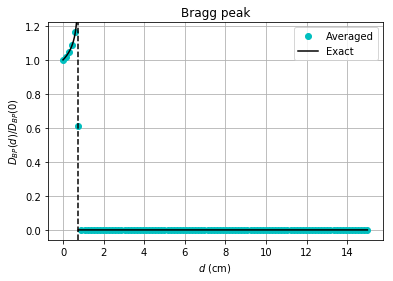

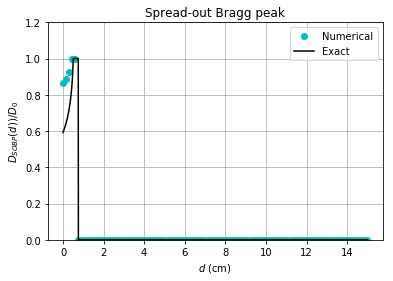

In tissue of density 1.1 gm/cm^3, to deliver proton radiation that spreads out over the desired target range of 0.5 cm to 0.75 cm, you should use a range of energies from 2.0394545839513065 to 4.58877281389044 MeV.
THIS INFORMATION IS NOT INTENDED FOR MEDICAL USE.
AM NOT A DOCTOR, THIS IS MEANT FOR DEMONSTRATION ONLY.


In [9]:
proton_therapy()

This is a use of this program to describe energies necessary to treat an eye tumor.  Close to the surface, low density.

What is the shallowest depth of the cancerous tissue (cm)?8
What is the deepest depth of the cancerous tissue (cm)?10
What is the density of the cancerous tissue? (g/cm^3)?2.3


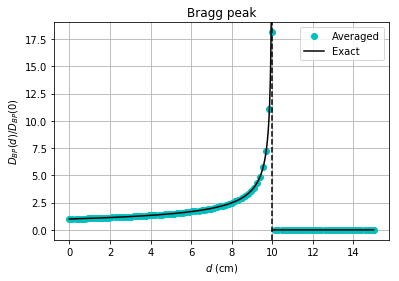

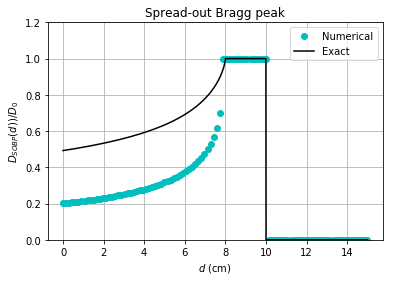

In tissue of density 2.3 gm/cm^3, to deliver proton radiation that spreads out over the desired target range of 8.0 cm to 10.0 cm, you should use a range of energies from 121.42647226070795 to 189.72886290735616 MeV.
THIS INFORMATION IS NOT INTENDED FOR MEDICAL USE.
AM NOT A DOCTOR, THIS IS MEANT FOR DEMONSTRATION ONLY.


In [10]:
proton_therapy()

This is a use of this program to estimate energies to treat cancer in bone.  Much higher density and depth of penetration.

What is the shallowest depth of the cancerous tissue (cm)?7.5
What is the deepest depth of the cancerous tissue (cm)?8.5
What is the density of the cancerous tissue? (g/cm^3)?1.3


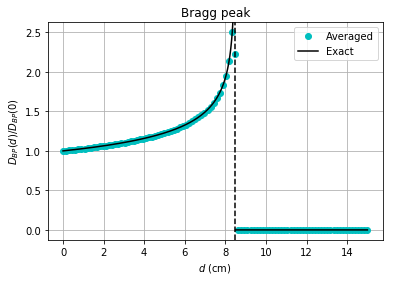

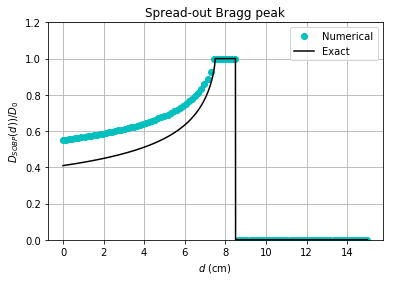

In tissue of density 1.3 gm/cm^3, to deliver proton radiation that spreads out over the desired target range of 7.5 cm to 8.5 cm, you should use a range of energies from 196.5175326147771 to 252.41585300298038 MeV.
THIS INFORMATION IS NOT INTENDED FOR MEDICAL USE.
AM NOT A DOCTOR, THIS IS MEANT FOR DEMONSTRATION ONLY.


In [11]:
proton_therapy()

This is the use of the program to estimate the energies to treat a tumor in soft muscle tissue.  Slightly higher density than the eye and greater depth.

I started with their notebook and I modified it so that it only prodcues graphs relevant to the question of my project.  I also used the terms in their program to estimate the energy of the protons delivered to those depths in MeVs so help explain how the proton beams for these treatments are produced. I tried some variations and couldn't get my loftiest goal to work out. I first tried to code the analytic solution as it appears in reference materials but I just couldn't get it work because some of the functions have dual outputs and I don't know how those parameters are used. I also tried building in widgets so that the bounds of the simulation could be changed with sliders but I couldn't figure out how to get it to change the graphs in real time using plotly. I wanted to have two sliders for target depth and a toggle for tissue type being penetrated. I have older versions of these same plots with those ideas but i scrapped them.

The main thing I did was figure out a way to estimate the energy depth range but thats a straight forward equation.  It actually utilizies a constant that isn't exactly 1 to produce final units of MeV but its so close that I didn't include the decimal (especially considering this isn't for medical use). I also figured out how the code works by going through it line by line when I was trying to insert the code to make sliders work. Concatenation is used to recursively calculate the energy loss of the particle until the critical value when the Bragg peak occurs but it's something that I'd need to study furthur to manipulate successfully.

I also put the whole thing in a "wrapper".  It's nothing special but it prompts the user for the important and imputs and produces the desired dose graph and estimated energy range to produce the SOBP.  It also outputs the crucial disclaimer about how I'm not a medical doctor. 

Reference: "Script which calculates the required weighting of individual Bragg peaks a to generate spread-out Bragg peak (SOBP). A numerical solution is compared to an exact one from Bortfeld & Schlegel, "An analytical approximation of depth-
dose distributions for therapeutic proton beams", Phys. Med. Biol. 41 (1996), 1331-1339. "

# Some Data Analysis:

So I couldn't think of a way to use the program above to analyze any of the data sets that I found, so I took some raw data from a paper about the topic of proton therapy and saw if I could reprodce the trends their paper discussed.  In the paper they use a monte carlo simulation to vary the amount of energy lost per "step" of the proton accordingly with the type of tissue it penetrates through.  Bone, lung and muscle tissue all have different atomic composition and their method attempts to use that information to create a superior calculation of dosimetry for proton therapy. 

In one of the papers I reference, Titt 2014, their research team developed a Monte Carlo model to validate the dosimetric accuracy of calculations done to determine how many protons to use in for a treatment in the Proton Therapy Center in Houston.  Their Monte Carlo simulation produced 191 models which matched 189 data sets to within 3% of the maximum dose difference.  Above is a graph of one of their actual data sets of measured energy delivery per depth.

In [11]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import seaborn as sns
 
df = pd.read_excel('Titt2008.xlsx', sheet_name='Units Removed')
 
print("Column headings:")
print(df.columns)

Column headings:
Index(['Ep', 'm', 'z', 'ΔP90–10', 'ΔP90–50', 'ΔP80–20', 'ΔFS', 'ΔDmax'], dtype='object')


In [12]:
for i in df.index:
   print(df['ΔDmax'][i])

3.0
1.5
0.9
0.8
0.9
1.0
0.9
1.5
1.9
1.5
1.8
2.5
2.0
3.0
2.3
2.6
3.0
2.1
2.0
2.2
0.9
3.5
1.5
2.4
2.6
1.0
0.9
4.0
2.4
2.7
2.1
3.0
1.0
0.9
0.9
1.5
1.0
0.8
1.0
1.0
0.8
0.9
1.0
1.0
1.3
1.8
1.3
1.0
3.0
0.9
0.9
1.0
1.1
0.7
1.0
1.0
0.9


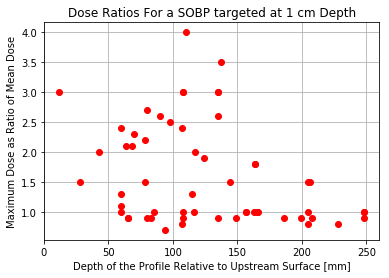

In [13]:
for i in df.index:
    x_1=np.array(df['z'])
for i in df.index:
    y_1=np.array(df['ΔDmax'])  

plt.plot(x_1, y_1, 'ro')
plt.grid()
plt.ylabel('Maximum Dose as Ratio of Mean Dose')
plt.xlabel('Depth of the Profile Relative to Upstream Surface [mm]')
plt.title("Dose Ratios For a SOBP targeted at 1 cm Depth")

plt.show()

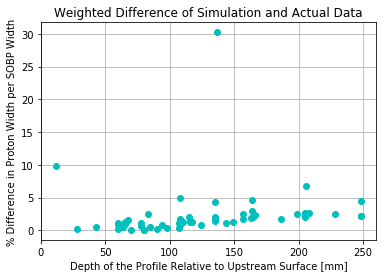

In [14]:
for i in df.index:
    x_2=np.array(df['z'])
for i in df.index:
    y_2=np.array(df['ΔP90–10'])
for i in df.index:
    a_2=np.array(df['ΔFS'])
    
b_2=y_2/a_2
    
plt.plot(x_2, b_2, 'co')
plt.grid()
plt.ylabel('% Difference in Proton Width per SOBP Width')
plt.xlabel('Depth of the Profile Relative to Upstream Surface [mm]')
plt.title("Weighted Difference of Simulation and Actual Data")

plt.show()

This graph shows the dose difference observed between the simulated protons and the actual protons per the differene in field size of the observed protons.  Despite a few outliers, this plot shows a small percent difference in the observed width of the proton and the simulated width of the proton per depth. Their complex Monte Carlo simulation is necessary for applying proton beams in medical applications because the Bragg Peak solutions involves assuming a constant density of of the material being irradiated. This is a bad assumption considering the diverse contents and complex structure of biological tissue.  The simulation come up with by Titt et. al considers the different atomic composition of different types of tissue and attempts to use these characterizations to improve calculations used in delivering doses of protons for medical treatment. 

I like using pandas for data analysis because it lets you use excel sheets to be able to visiually look at and manipulate the data in a more straight forward environment.  It might be a crutch right now, but it was useful in analyzing the data from the paper I referenced because they included their data as a table in a word document and it was easiet to read it into python by copying it into an excel sheet.

Reference: Titt, U et al. (2008). “Assessment of the accuracy of an MCNPX-based MonteCarlo simulation model for predicting three-dimensional absorbed dose dis-tributions.” In:Physics in medicine and biology53.16, pp. 4455–70.issn:0031-9155.doi:10.1088/0031-9155/53/16/016.url:http://www.ncbi.nlm.nih.gov/pubmed/18670050%20http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=PMC4131262.